https://www.ritchievink.com/blog/2019/05/24/algorithm-breakdown-expectation-maximization/

The first part of this post will focus on Gaussian Mixture Models, as expectation maximization is the standard optimization algorithm for these models. The second part of the post, we will focus on a broader view on expectation maximization, and we will get the mathematical intuition of what we are optimizing.

# Gaussian Mixture Model

The schoolbook example of *Expectation Maximization* starts with a Gaussian Mixture model. Below we will go through the definition of a GMM in 1D, but note that his will generalize to $N$ dimensions. Gaussian Mixtures help with the following clustering problem. Assume a generative process where $X$ is an observed random variable.
$$
\begin{split}
z_i &\sim Multinomial(\phi)\\
x_i|z_i &\sim \mathcal{N}(\mu_k, \sigma_k^2)
\end{split}
$$
$x_i$ is sampled from two different Gaussians. $z_i$ is an unobserved variable that determines from which Gaussian is sampled. Note that in this 1D case, the Multinomial distribution is a Bernoulli distribution since there are only two Gaussians ($k=2$). The parameter $\phi_j$ gives $p(z_i = j)$. We could generate this data in `python` as follows:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [3]:
np.random.seed(654)
# Draw samples from two gaussians w.p. z_i ~ bernoulli(phi)
generative_m = np.array([stats.norm(2, 1),      # gaussian mean = 2 with var = 1
                         stats.norm(5, 1.8)])   # gaussian mean = 5 with var = 1.8
z_i = stats.bernoulli(0.75).rvs(100)
x_i = np.array([g.rvs() for g in generative_m[z_i]])

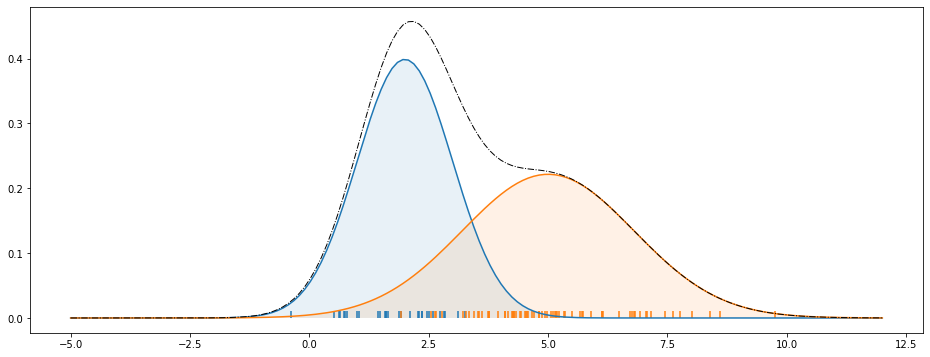

In [4]:
# plot generated data and the latent distributions
x = np.linspace(-5, 12, 150)
plt.figure(figsize=(16, 6))
plt.plot(x, generative_m[0].pdf(x))
plt.plot(x, generative_m[1].pdf(x))
plt.plot(x, generative_m[0].pdf(x) + generative_m[1].pdf(x), lw=1, ls='-.', color='black')
plt.fill_betweenx(generative_m[0].pdf(x), x, alpha=0.1)
plt.fill_betweenx(generative_m[1].pdf(x), x, alpha=0.1)
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z_i])

# Expectation-Maximization in GMM

The log-likelihood of the model is defined below, but because $Z$ is unobserved, the log-likelihood function has no closed form for the maximum likelihood.
$$
\begin{split}
l(\theta) &= \sum_{i=1}^n \log p(x_i; \theta) \\
          &= \sum_{i=1}^n \log \sum_{k=1}^K p(x_i, z_i; \theta) \\
          &= \sum_{i=1}^n \log \sum_{k=1}^K p(x_i|z_i; \theta) p(z_i; \theta)
\end{split}
$$
This is the reason why we will use an optimization algorithm called *Expectation-Maximization*, where we guess $Z$ and iteratively try to maximize the log-likelihood.

## E-step
Given a set of initialized parameters, we determine $w_{ij}$ for each data point $x_i$:
$$
\begin{split}
w_{ij} &:= p(z_i = j | x_i; \theta) \\
       &=  \frac{p(x_i|z_i = j) p(z_i = j)}{p(x_i)} \\
       &\propto  \mathcal{N}(x_i|\mu_j, \sigma_j) \phi_j
\end{split}
$$
In other words: what is the likelihood that data point $x_i$ was generated by the $j^{th}$ Gaussian?

## M-step

Based on the (re)computed responsibilities $w_{ij}$ in the E-step, we now compute the means and variances of the underlying Gaussian distributions.
$$
\begin{split}
\phi_j   &:= frac{1}{n} \sum_{i=1}^{n} w_{ij} \\
\mu_j    &:= \frac{\sum_{i=1}^{n} w_{ij} x_i}{\sum_{i=1}^{n} w_{ij}} \\
\sigma_j &:= \sqrt{ \frac{\sum_{i=1}^{n} w_{ij} (x_i - \mu_j)^2}{\sum_{i=1}^{n} w_{ij}} }
\end{split}
$$
If we iterate the E-M steps, we hope to converge to a the maximum likelihood. However, because the log-likelihood is multi-modal, we could get stuck in a local optimum.


In [5]:
class EM:
    def __init__(self, k):
        "k = number of hidden variables"
        self.k = k
        self.mu = None # will be initialized later, based on x's
        self.std = np.ones(k)
        self.w_ij = None
        self.phi = np.ones(k) / k
    
    def expectation_step(self, x):
        for z_i in range(self.k):
            self.w_ij[z_i] = stats.norm(self.mu[z_i], self.std[z_i]).pdf(x) * self.phi[z_i]
        # normalize so that marginalizing z would lead to p = 1
        self.w_ij /= self.w_ij.sum(0)
    
    def maximization_step(self, x):
        self.phi = self.w_ij.mean(1)
        self.std = ((self.w_ij * (x - self.mu[:, None])**2).sum(1) / self.w_ij.sum(1))**0.5
        self.mu  = (self.w_ij * x).sum(1) / self.w_ij.sum(1)
    
    def fit(self, x):
        # initialize
        self.mu = np.random.uniform(x.min(), x.max(), size=self.k)
        self.w_ij = np.zeros((self.k, x.shape[0]))

        # iteration
        last_mu = np.ones(self.k) * np.inf
        while ~np.all(np.isclose(self.mu, last_mu)):
            last_mu = self.mu
            self.expectation_step(x)
            self.maximization_step(x)


In [6]:
m = EM(2)
m.fit(x_i)

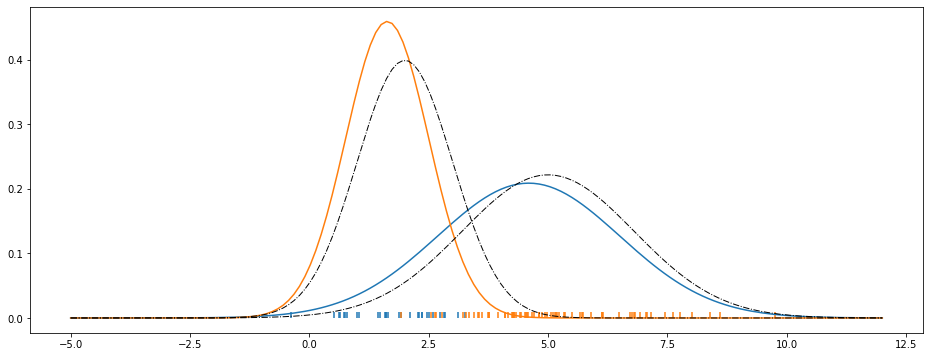

In [7]:
fitted_m = [stats.norm(mu, std) for mu, std in zip(m.mu, m.std)]

plt.figure(figsize=(16, 6))
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z_i])
plt.plot(x, fitted_m[0].pdf(x))
plt.plot(x, fitted_m[1].pdf(x))
plt.plot(x, generative_m[0].pdf(x), color='black', lw=1, ls='-.')
plt.plot(x, generative_m[1].pdf(x), color='black', lw=1, ls='-.')

# General Expectation Maximization

Above, we've shown EM in relation to GMMs. However, EM can be applied in a more general sense to a wider range of algorithms. We noted earlier that we cannot optimize the log-likelihood $\log p(\mathbf{X}) = \sum_{x_i} \log \sum_{z_i} p(x_i, z_i)$ because we haven't observed $Z$. However, we can find a lower bound to the log-likelihood, which we can optimize.

In the figure below, we see the intuition behind optimizing a lower bound on the log-likelihood $\log p(\mathbf{X})$ (in red). The green bound is tighter than the blue bound, and hence gives a better estimate. $g$ is a lower bound  of a function $f$ is $g(x) \leq f(x)$ for all $x$ in its domain.


![Iteratively maximizing a lower bound of $l(\theta)$](https://www.ritchievink.com/img/post-24-em/lower_bound_functions.png)

## Jensen's inequality
How do we obtain a lower bound function of the log-likelihood? Jensen's inequality theorem states that for every strictly concave function $f$ (i.e. $f'' < 0$ for the whole domain range $x$) applied on a random variable $X$:
$$
E[f(X)] \leq f(E[X])
$$
This inequality will be an equality iff $X = E[x]$ with probaility $1$. In other words, if X is a constant.

Below, we'll get some intuition for the theorem. We define a range of $x = 1\ldots 15$, take $\log$ as function $f(x)$ and compute the *lhs* and *rhs* of Jensens inequality. For plotting purposes, the theorem is applied on the full range, where we normally would apply it to samples from a probability distribution.

Text(0, 1.7400900355430748, '$E[f(x)])$')

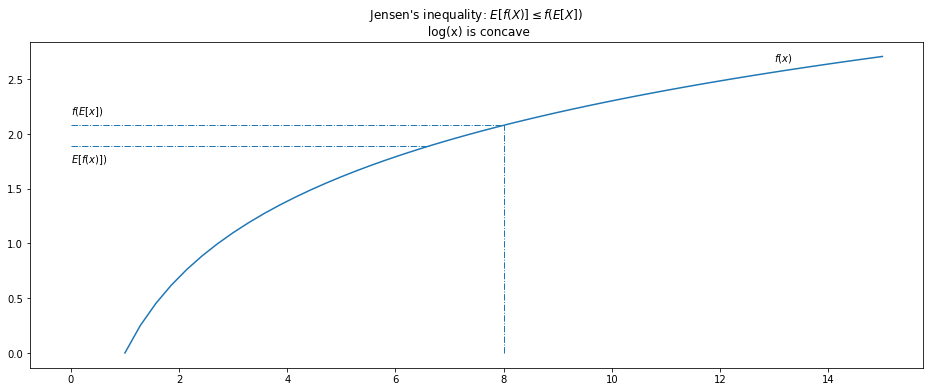

In [15]:
x = np.linspace(1, 15)

plt.figure(figsize=(16, 6))
plt.title('Jensen\'s inequality: $E[f(X)] \leq f(E[X])$ \n log(x) is concave')
plt.plot(x, np.log(x))
plt.annotate(r'$f(x)$', (13, np.log(13) + 0.1))

plt.hlines(np.log(np.mean(x)), 0, np.mean(x), linestyles='-.', lw=1)
plt.vlines(np.mean(x), 0, np.log(np.mean(x)), linestyles='-.', lw=1)
plt.annotate(r'$f(E[x])$', (0, np.log(np.mean(x)) + 0.1))

plt.hlines(np.mean(np.log(x)), 0, np.exp(np.mean(np.log(x))), linestyles='-.', lw=1)
plt.annotate(r'$E[f(x)])$', (0, np.mean(np.log(x)) - 0.15))

## The Evidence Lower Bound (ELBO)

Now we are going to define a lower bound on the *evidence* $p(x)$. The marginal likelihood over $Z$ if often intractable, as we need to integrate over all possible values of $z_i$ to compute it.

Recall that we are trying to optimize the evidence $p(\mathbf{X}; \theta)$ under the current guess of the parameters $\theta$.
$$
l(\theta) = p(\mathbf{X}; \theta) = \sum_{i=1}^n \log p(x_i; \theta)
$$
As we assume a latent variable $Z$ that we can't observe, we rewrite the evidence including $z_i$, which is marginalized out:
$$
l(\theta) = p(\mathbf{X}; \theta) = \sum_{i=1}^n \log \sum_{z_i} p(x_i, z_i; \theta)
$$
Multiply this equation with an arbitrary distribution over $Z$: $\frac{Q(z)}{Q(z)} = 1$:
$$
l(\theta) = p(\mathbf{X}; \theta) = \sum_{i=1}^n \log \sum_{z_i} Q(z_i) \frac{p(x_i; \theta)}{Q(z_i)}
$$
Note that the expectation $E[Z]$ of a random variable $Z$ is defined as as $E[Z]=\sum_{x} x p(x)$. This means that we can rewrite the log-likelihood as
$$
l(\theta) = \sum_{i=1}^n \log E_{z\sim Q}\Bigg[ \frac{p(x_i, z; \theta)}{Q(z)} \Bigg]
$$
As the log function is concave, we can apply Jensen's inequality to the right-hand side of the equation, which enables us to put the logarithm **inside** the expectation:
$$
\sum_{i=1}^n \log E_{z\sim Q}\Bigg[ \frac{p(x_i, z; \theta)}{Q(z)} \Bigg] \geq 
\sum_{i=1}^n E_{z\sim Q} \Bigg[\log \frac{p(x_i, z; \theta)}{Q(z)} \Bigg] 
$$

We can now continue with this lower bound, and unpack the expectation in the summation form:
$$
l(\theta) \geq \sum_{i=1}^n \sum_{z_i} Q(z_i) \log \frac{p(x_i, z; \theta)}{Q(z)}
$$
The equation above holds for every distribution we choose for $Q(z)$, but ideally we want to choose a distribution that leads to a lower bound that is close to the true log-likelihood function. 
...

## Relation to Expectation-Maximization
In the section above, we've found a lower bound on the log-likelihood for the current values of $\theta$ and $Q(z)$. Our goal is to optimize $\theta$ so that we maximize the log-likelihood $\log p(x; \theta)$. Because we can't optimize this function directly, we try to optimize its lower bound $\sum_{i=1}^n \sum_{z_i} Q(z_i) \log \frac{p(x_i, z; \theta)}{Q(z)}$.

This lower bound would be equal to the log-likelihood if we choose $Q(z) = p(z|x; \theta)$. Based on the current parameters $\theta_t$ and $Q(z)$, we optimize $\theta_{t+1}$. However, once we do the optimization step, Jensen's equality doesn't hold anymore as $Q(z)$ is still parametrized on the previous values of the parameter $\theta_t$. For this reason, we optimize in 2 steps:

1. The **Expectation** step: Under the current parameters $\theta_t$, find $Q(z) = p(z|x; \theta_t)$

1. The **Maximization** step: With $Q(z; \theta_t)$, optimize the lower bound bound of the log-likelihood: $argmax_\theta ELBO(x; Q, \theta)$ so that we obtain $\theta_{t+1}$.

This is exactly what we did in the Gaussian-Mixture example. First, we set $w_{ij} := p(z_i = j | x_i; \theta, \phi)$ and then we used $w_{ij}$ to find $\theta